# Traffic Demand Forecasting

For this project, I analyzed a historical dataset of hourly car counts on different highways with time series analysis and machine learning to predict future traffic. The dataset I used was provided by user FEDESORIANO on Kaggle.

https://www.kaggle.com/datasets/fedesoriano/traffic-prediction-dataset

Import all necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

Then, read in the dataset. The dataset consists of  48.1k (48120) observations of the number of vehicles each hour in four different junctions in the following columns:

​

1) DateTime

2) Juction

3) Vehicles

4) ID

​

I set the index as the dates and time. I dropped the 'ID' column, as it isn't necessary to achieve the goal of this project.

In [2]:
# https://www.kaggle.com/datasets/fedesoriano/traffic-prediction-dataset
# Read the data
df = pd.read_csv('/Users/KaryLy/Desktop/datasets/traffic.csv')
df = df.set_index('DateTime')
df = df.drop(columns='ID')
df.index = pd.to_datetime(df.index)
df.head()

,Junction,Vehicles
DateTime,,
2015-11-01 00:00:00,1,15
2015-11-01 01:00:00,1,13
2015-11-01 02:00:00,1,10
2015-11-01 03:00:00,1,7
2015-11-01 04:00:00,1,9


I decided to create a pivot table to make the dataset easier to use. The columns are the date and junctions and the values are the average vehicle count for a specific hour. I replaced NaN values with 0.0.

In [3]:
# Creating a pivot table where the columns are the date and junctions and the values are the average vehicle count 
# for that time
traffic = df.pivot_table(index='DateTime', columns='Junction', values='Vehicles', 
                                    aggfunc='mean').fillna(0.0)
traffic.head()

Junction,1,2,3,4
DateTime,,,,
2015-11-01 00:00:00,15.0,6.0,9.0,0.0
2015-11-01 01:00:00,13.0,6.0,7.0,0.0
2015-11-01 02:00:00,10.0,5.0,5.0,0.0
2015-11-01 03:00:00,7.0,6.0,1.0,0.0
2015-11-01 04:00:00,9.0,7.0,2.0,0.0


Here, I plotted the hourly traffic by junction so we can see the data much clearer. Notice that prior to January 2017, there is no data for junction 4. It's possible that junction 4 did not exist before 2017.

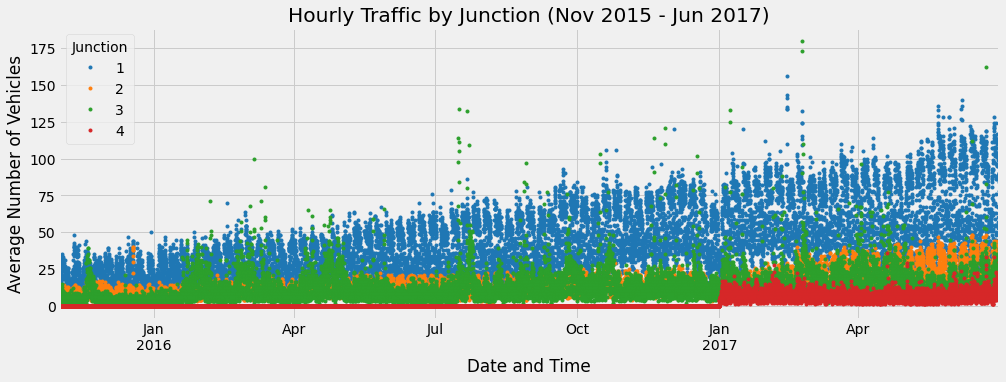

In [4]:
# Plot the data
traffic.plot(style='.', figsize=(15, 5), color=[color_pal[0], color_pal[1], color_pal[2], color_pal[3]])
plt.title('Hourly Traffic by Junction (Nov 2015 - Jun 2017)')
plt.xlabel('Date and Time')
plt.ylabel('Average Number of Vehicles')
plt.legend(title='Junction')
plt.show()

# Train / Test Split

I split the data on March 1st, 2017. Everything before March 1st, 2017 is the training data and the test data is the following dates. I then plotted the split to make everything easier to visualize.

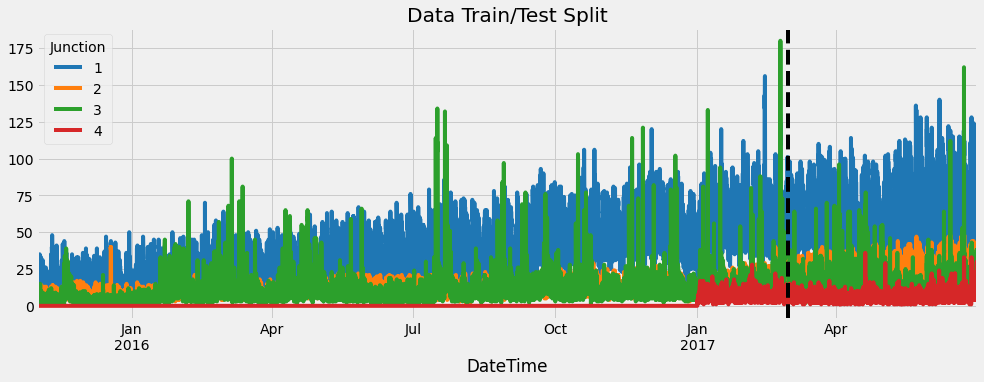

In [5]:
# Splitting the data between 3-01-2017 and showing the split on a plot
train = traffic.loc[traffic.index < '03-01-2017']
test = traffic.loc[traffic.index >= '03-01-2017']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split', color=[color_pal[0], 
                                                                              color_pal[1], color_pal[2], 
                                                                              color_pal[3]])
test.plot(ax=ax, label='Test Set', color=[color_pal[0], color_pal[1], color_pal[2], color_pal[3]])
ax.axvline('03-01-2017', color='black', ls='--')
ax.legend(['1', '2', '3', '4'], title='Junction')
plt.show()

We can also look at what one single week of data would look like. I chose the week of January 1st to 8th of 2017. These are dates are from Sunday to Saturday. Some general trends to note are that there is more traffic during the weekdays across all junctions. A possible reason for this could be that a lot of people commute to work on the weekdays, resulting in more traffic. However, there is also a very big peak on junction 3 on January 8th. January 8th was a Saturday, so there could've be many people driving out to do activities on the weekend. It's also important to note that January 1st was a holiday, so many people could've been celebrating at home, resulting in less traffic.

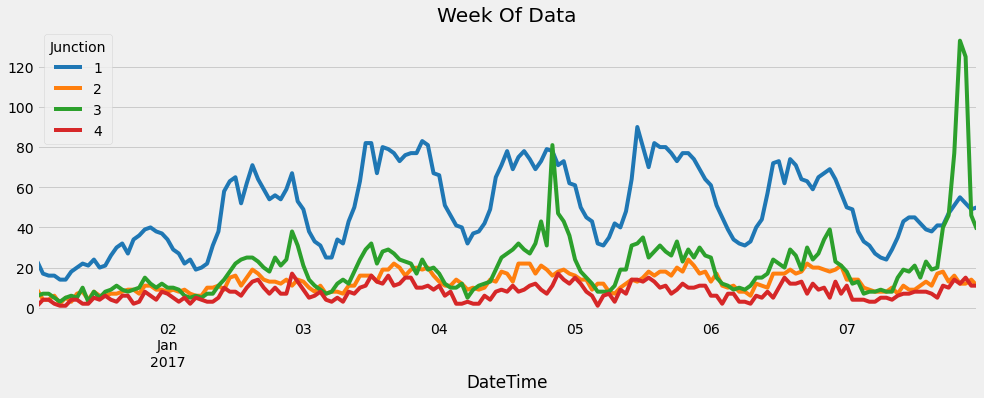

In [6]:
traffic.loc[(traffic.index > '01-01-2017') & (traffic.index < '01-08-2017')] \
    .plot(figsize=(15, 5), title='Week Of Data', color=[color_pal[0], color_pal[1], color_pal[2], color_pal[3]])
plt.show()

# Feature Creation

Feature creation helps make it so that we can see how the data is affected by different times. Here, I created a function that would convert the "DateTime" column into different time series features.

In [7]:
# Create the features
def time_series_features(df):
    df = df.copy()
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week.astype(int)
    df['dayofweek'] = df.index.dayofweek
    df['year'] = df.index.year
    df['hour'] = df.index.hour
    return df

traffic = time_series_features(traffic)

traffic.head()

Junction,1,2,3,4,quarter,month,dayofyear,weekofyear,dayofweek,year,hour
DateTime,,,,,,,,,,,
2015-11-01 00:00:00,15.0,6.0,9.0,0.0,4,11,305,44,6,2015,0
2015-11-01 01:00:00,13.0,6.0,7.0,0.0,4,11,305,44,6,2015,1
2015-11-01 02:00:00,10.0,5.0,5.0,0.0,4,11,305,44,6,2015,2
2015-11-01 03:00:00,7.0,6.0,1.0,0.0,4,11,305,44,6,2015,3
2015-11-01 04:00:00,9.0,7.0,2.0,0.0,4,11,305,44,6,2015,4


# Visualize Feature / Target Relationship

With the time series features, we can plot the relationship between the features and target. I plotted each junction's average vehicle count by hour. I also plotted each junction's vehicle count by day.

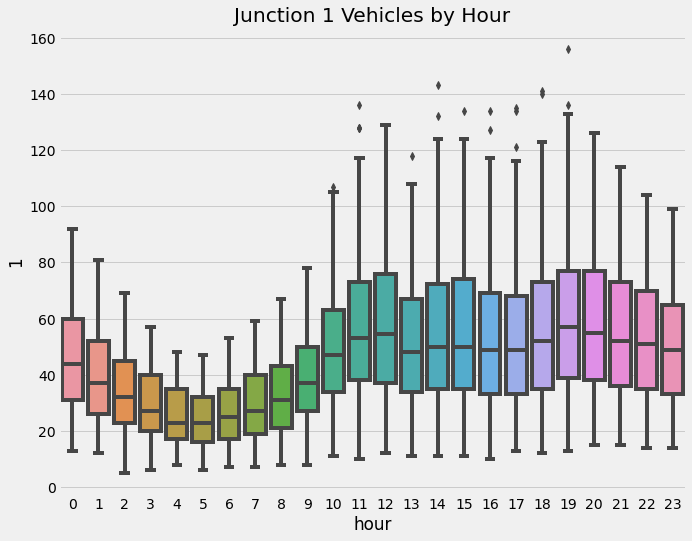

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=traffic, x='hour', y=1)
ax.set_title('Junction 1 Vehicles by Hour')
plt.show()

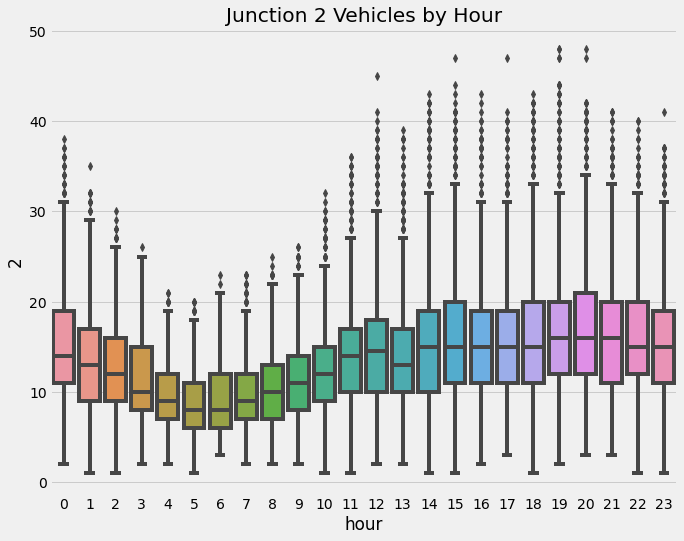

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=traffic, x='hour', y=2)
ax.set_title('Junction 2 Vehicles by Hour')
plt.show()

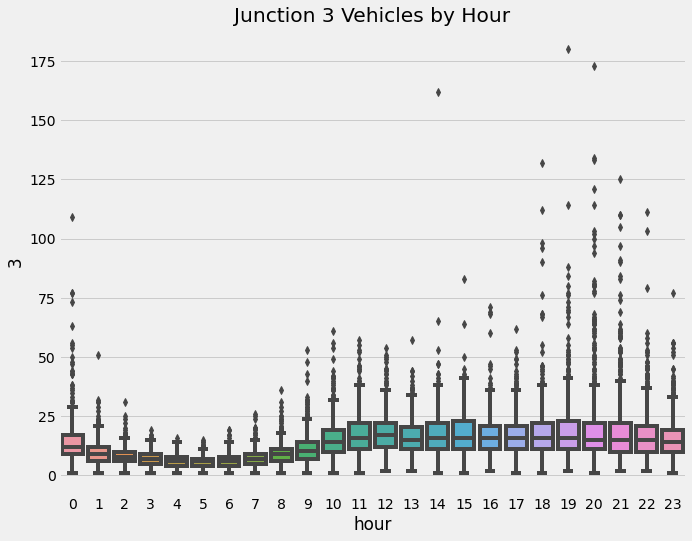

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=traffic, x='hour', y=3)
ax.set_title('Junction 3 Vehicles by Hour')
plt.show()

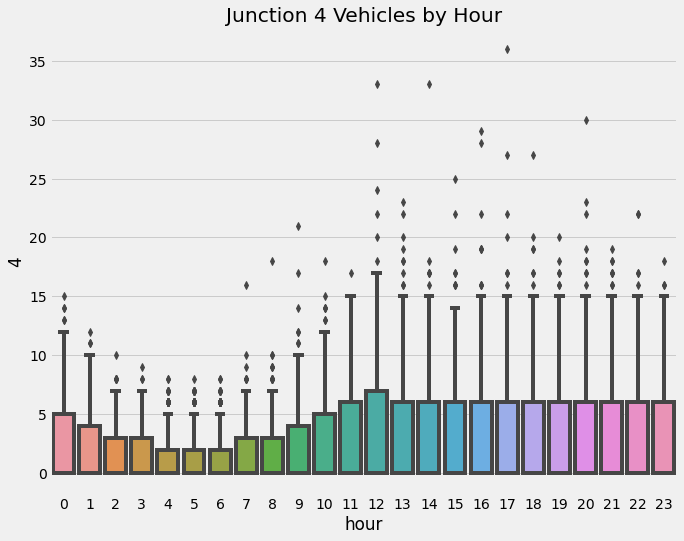

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=traffic, x='hour', y=4)
ax.set_title('Junction 4 Vehicles by Hour')
plt.show()

All of the junctions follow a pretty similar pattern when compared to hours. Early in the morning, there is a dip in car counts. The amount of cars then increases from 8 A.M. to 12 P.M. and decreases a bit in the afternoons. It increases again in the evenings. This could be due to people going to work from 8 A.M. to 12 P.M. and then going back home in the evenings.

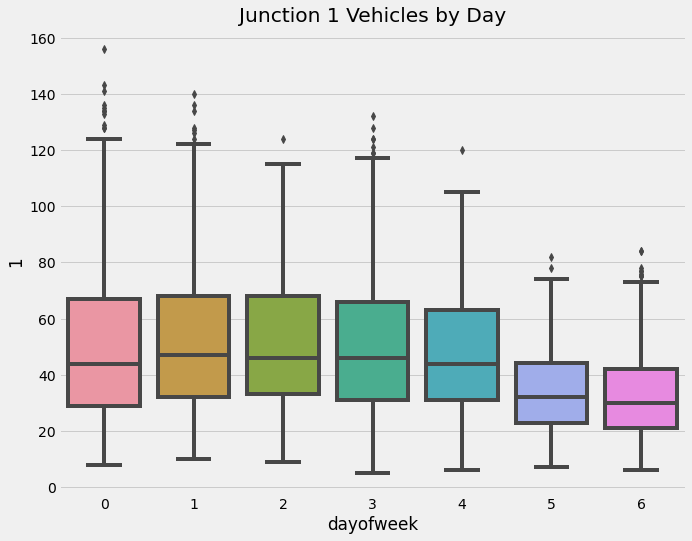

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=traffic, x='dayofweek', y=1)
ax.set_title('Junction 1 Vehicles by Day')
plt.show()

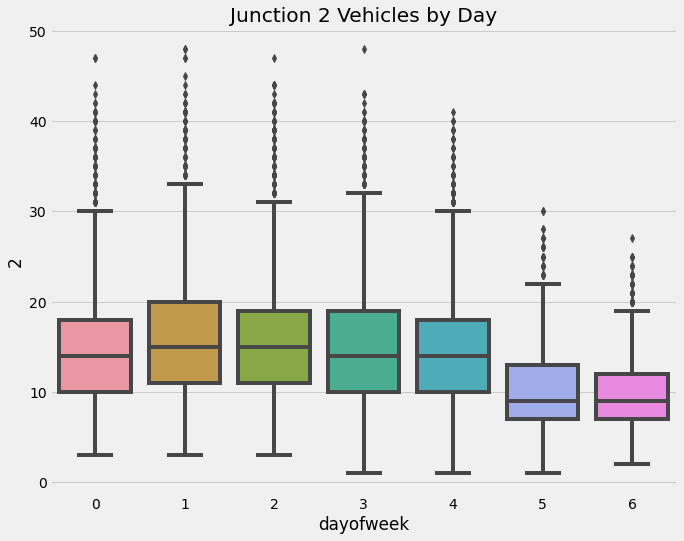

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=traffic, x='dayofweek', y=2)
ax.set_title('Junction 2 Vehicles by Day')
plt.show()

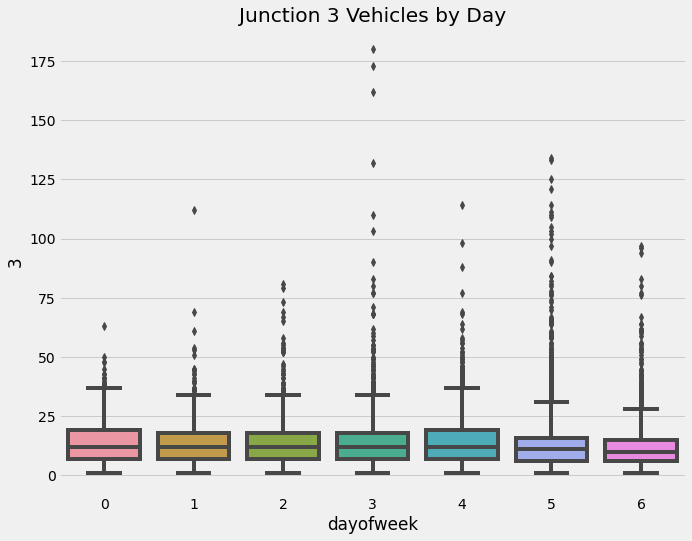

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=traffic, x='dayofweek', y=3)
ax.set_title('Junction 3 Vehicles by Day')
plt.show()

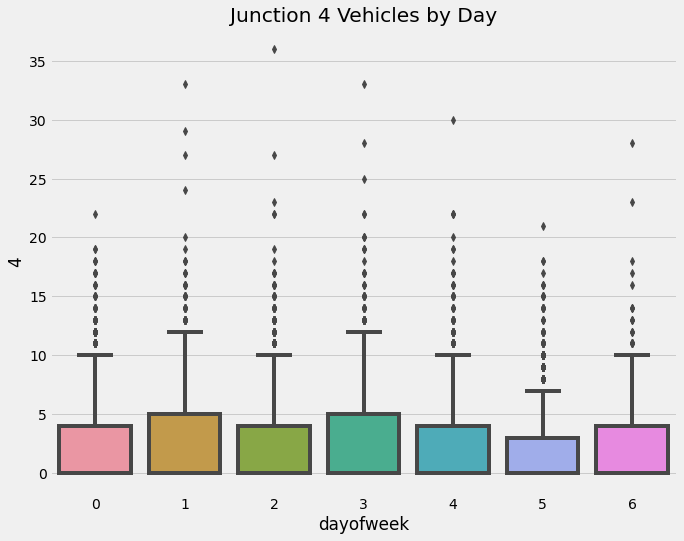

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=traffic, x='dayofweek', y=4)
ax.set_title('Junction 4 Vehicles by Day')
plt.show()

Each junction also follows a similar pattern to each other for the days of the week (0 = Monday, 6 = Sunday). The amount of cars peaks during the weekdays and dips during the weekends. Again, this could be due to people going to work on the weekdays and staying home during the weekends.

# Creating the Model

This code essentially performs feature engineering, prepares the data, initializes an XGBoost regressor with specific hyperparameters, and then trains the model while monitoring its performance on both the training and testing sets. The early_stopping_rounds parameter ensures that training stops if the model's performance on the testing set doesn't improve for a certain number of rounds.

In [17]:
# Create the model
train = time_series_features(train)
test = time_series_features(test)

features = ['quarter', 'month', 'dayofyear', 'weekofyear', 'dayofweek', 'year', 'hour']
target = [1, 2, 3, 4]

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3, learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[16:33:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:23.80156	validation_1-rmse:38.57273
[100]	validation_0-rmse:11.00864	validation_1-rmse:19.78985
[200]	validation_0-rmse:7.01963	validation_1-rmse:12.71785
[300]	validation_0-rmse:5.72827	validation_1-rmse:10.03525
[400]	validation_0-rmse:5.23989	validation_1-rmse:8.90330
[500]	validation_0-rmse:4.99062	validation_1-rmse:8.39067
[600]	validation_0-rmse:4.83872	validation_1-rmse:8.15699
[700]	validation_0-rmse:4.72279	validation_1-rmse:7.99541
[800]	validation_0-rmse:4.62565	validation_1-rmse:7.87066
[900]	validation_0-rmse:4.53683	validation_1-rmse:7.76933
[999]	validation_0-rmse:4.46853	validation_1-rmse:7.69339


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

The Root Mean Squared Error (RMSE) should decrease as the model trains and improves. The RMSE is a measure of how well the predicted values of the model match the actual target values in the dataset. As the model learns from the data and adjusts its parameters, it should become better at making accurate predictions, leading to a decrease in the RMSE.

# Feature Importance

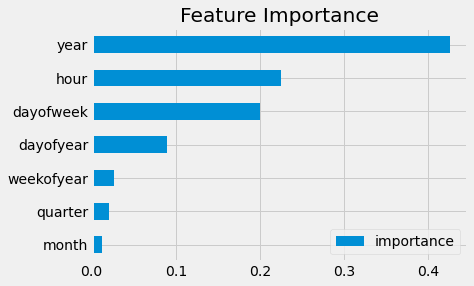

In [18]:
# Finding the most important feature
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

The model has been using the year, hour, and dayofweek features the most in each of the trees.

# Forecast on Test

Here, I forecasted on the X_test set. I forecasted on each of the junctions and added them to the test dataframe.

In [19]:
# Predicting the average vehicle count in each junction 
predictions = reg.predict(X_test)

for i in range(4):
    test[f'prediction {i+1}'] = predictions[:, i]
    
test

Junction,1,2,3,4,quarter,month,dayofyear,weekofyear,dayofweek,year,hour,prediction 1,prediction 2,prediction 3,prediction 4
DateTime,,,,,,,,,,,,,,,
2017-03-01 00:00:00,75.0,31.0,23.0,8.0,1,3,60,9,2,2017,0,63.254105,23.673849,16.935415,7.443825
2017-03-01 01:00:00,57.0,27.0,14.0,5.0,1,3,60,9,2,2017,1,57.383556,22.401564,13.692346,6.269322
2017-03-01 02:00:00,58.0,24.0,9.0,5.0,1,3,60,9,2,2017,2,51.522858,21.144188,11.906451,5.191305
2017-03-01 03:00:00,50.0,22.0,6.0,5.0,1,3,60,9,2,2017,3,47.310295,19.915966,11.047853,4.825380
2017-03-01 04:00:00,42.0,17.0,6.0,5.0,1,3,60,9,2,2017,4,44.187233,18.370136,10.551672,4.743822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-30 19:00:00,105.0,34.0,33.0,11.0,2,6,181,26,4,2017,19,75.487625,24.746664,23.727129,9.759617
2017-06-30 20:00:00,96.0,35.0,31.0,30.0,2,6,181,26,4,2017,20,75.487625,24.826696,23.727129,9.760390
2017-06-30 21:00:00,90.0,31.0,28.0,16.0,2,6,181,26,4,2017,21,74.686005,24.784960,23.469925,9.758998


Now we can see all the predictions plotted on top of the training data. 

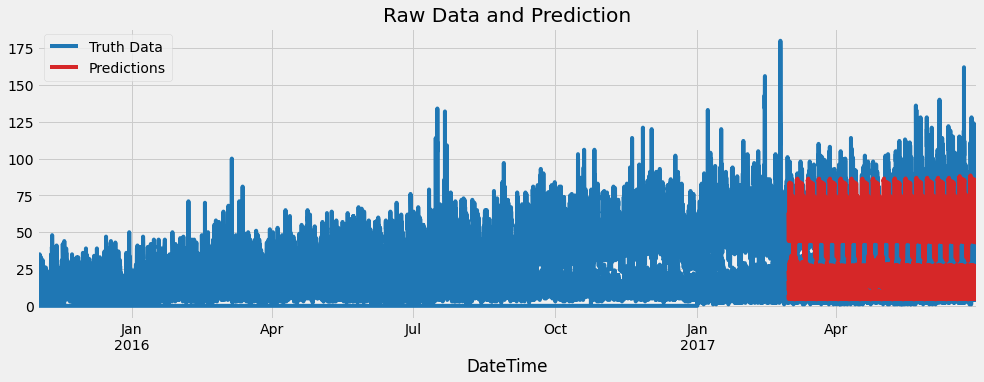

In [20]:
# Plot the predicted data against the actual data
traffic = traffic.merge(test[['prediction 1', 'prediction 2', 'prediction 3', 'prediction 4']], how='left', 
              left_index=True, right_index=True)
ax = traffic[[1, 2, 3, 4]].plot(figsize=(15, 5), color='#1f77b4')
traffic[['prediction 1', 'prediction 2', 'prediction 3', 'prediction 4']].plot(ax=ax, color='#d62728')
ax.set_title('Raw Data and Prediction')
ax.legend(['Truth Data', 'Predictions'])
leg = ax.get_legend()
leg.legendHandles[0].set_color('#1f77b4')
leg.legendHandles[1].set_color('#d62728')
plt.show()

I also plotted the predictions on a week's worth of data.

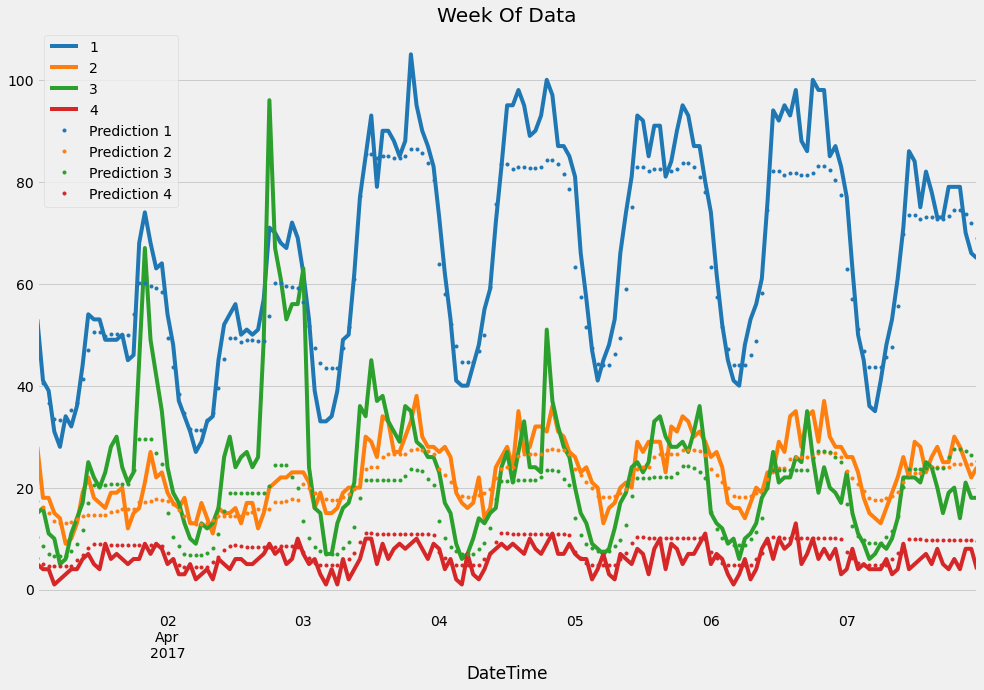

In [21]:
# Plot the predicted data against the actual data on a random week
ax = traffic.loc[(traffic.index > '04-01-2017') & (traffic.index < '04-08-2017')][[1, 2, 3, 4]].plot(
    figsize=(15, 10), title='Week Of Data', color=[color_pal[0], color_pal[1], color_pal[2], color_pal[3]])
traffic.loc[(traffic.index > '04-01-2017') & (traffic.index < '04-08-2017')][['prediction 1', 
                                                                              'prediction 2', 'prediction 3', 
                                                                              'prediction 4']].plot(ax=ax, style='.',
                                                                                                    color=
                                                                                                   [color_pal[0],
                                                                                                   color_pal[1], 
                                                                                                   color_pal[2],
                                                                                                   color_pal[3]])
ax.legend(['1', '2', '3', '4', 'Prediction 1', 
           'Prediction 2', 'Prediction 3', 'Prediction 4'])
plt.show()

Clearly, the model isn't perfect. There could be better parameter tuning or features for specific days of the year such as holidays. However, the predictions on the test set do follow the trends you would expect during the weekdays, weekends, and specific hours.

# Score (RMSE)

In [22]:
# RMSE score on each test
score_1 = np.sqrt(mean_squared_error(test[1], test['prediction 1']))
score_2 = np.sqrt(mean_squared_error(test[2], test['prediction 2']))
score_3 = np.sqrt(mean_squared_error(test[3], test['prediction 3']))
score_4 = np.sqrt(mean_squared_error(test[4], test['prediction 4']))
print(f'RMSE Score on Test set Junction 1: {score_1:0.2f}')
print(f'RMSE Score on Test set Junction 2: {score_2:0.2f}')
print(f'RMSE Score on Test set Junction 3: {score_3:0.2f}')
print(f'RMSE Score on Test set Junction 4: {score_4:0.2f}')

RMSE Score on Test set Junction 1: 11.14
RMSE Score on Test set Junction 2: 5.56
RMSE Score on Test set Junction 3: 8.53
RMSE Score on Test set Junction 4: 2.99


# Calculate Error

Here, I took a look at the worst predicted days. The block below returns the greatest differences in the predicted and actual values.

In [23]:
# Worst predicted days
test['error 1'] = np.abs(test[1] - test['prediction 1'])
test['error 2'] = np.abs(test[2] - test['prediction 2'])
test['error 3'] = np.abs(test[3] - test['prediction 3'])
test['error 4'] = np.abs(test[4] - test['prediction 4'])
test['date'] = test.index.date
error_columns = ['error 1', 'error 2', 'error 3', 'error 4']
mean_errors_by_date = test.groupby(['date'])[error_columns].mean()
top_dates_by_error = mean_errors_by_date.mean(axis=1).sort_values(ascending=False).head(10)

print(top_dates_by_error)

date
2017-06-22    11.516927
2017-06-27     9.959635
2017-06-13     9.944889
2017-05-22     8.810710
2017-06-06     8.802788
2017-06-29     8.370250
2017-06-28     8.355421
2017-06-14     8.186838
2017-06-30     7.921024
2017-06-19     7.666330
dtype: float64


# Outlier Analysis and Removal

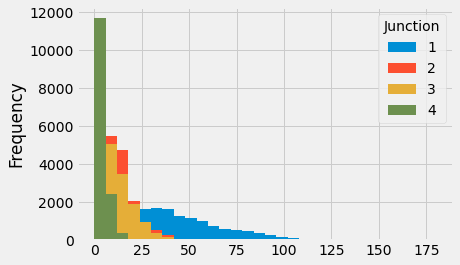

In [24]:
# Let's start removing outliers
traffic[[1, 2, 3, 4]].plot(kind='hist', bins=30);

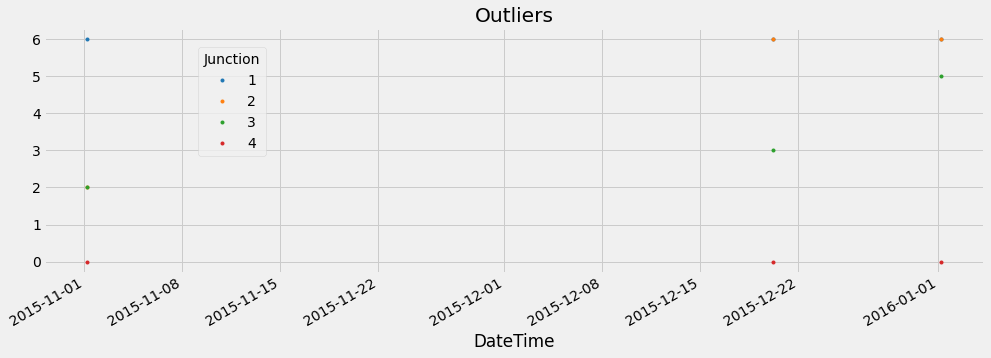

In [25]:
traffic = traffic.rename(columns={1: 'junction 1', 2: 'junction 2', 3: 'junction 3', 4: 'junction 4'})
# Plot outliers
outliers = traffic.query('`junction 1` < 7 and `junction 2` < 7 and `junction 3` < 7 and `junction 4` < 7')
ax = outliers[['junction 1', 'junction 2', 'junction 3', 'junction 4']].plot(style='.', figsize=(15, 5), 
                                                                        color=[color_pal[0], color_pal[1],
                                                                               color_pal[2], color_pal[3]],
                                                                               title='Outliers')
ax.legend(['1', '2', '3', '4'], loc='center', bbox_to_anchor=(0.2, 0.7), title='Junction');

In [26]:
# We get rid of the outliers by only keeping values above 7
traffic = traffic.query('`junction 1` > 7 and `junction 2` > 7 and `junction 3` > 7 and `junction 4` > 7').copy()

# Time Series Cross Validation

Data is collected on an hourly basis and we want to capture strong daily patterns in your cross-validation, 
so we could consider using a test_size that corresponds to a full day or multiple days. 
This means test_size is set to 24 hours (for one day) or a multiple of 24 hours (for multiple days).
To ensure a clear separation between training and testing periods, a gap should be set to at least one full day 
(24 hours) or more. This would prevent any overlap between the training and testing data.
I'm going to use a test size of one week.

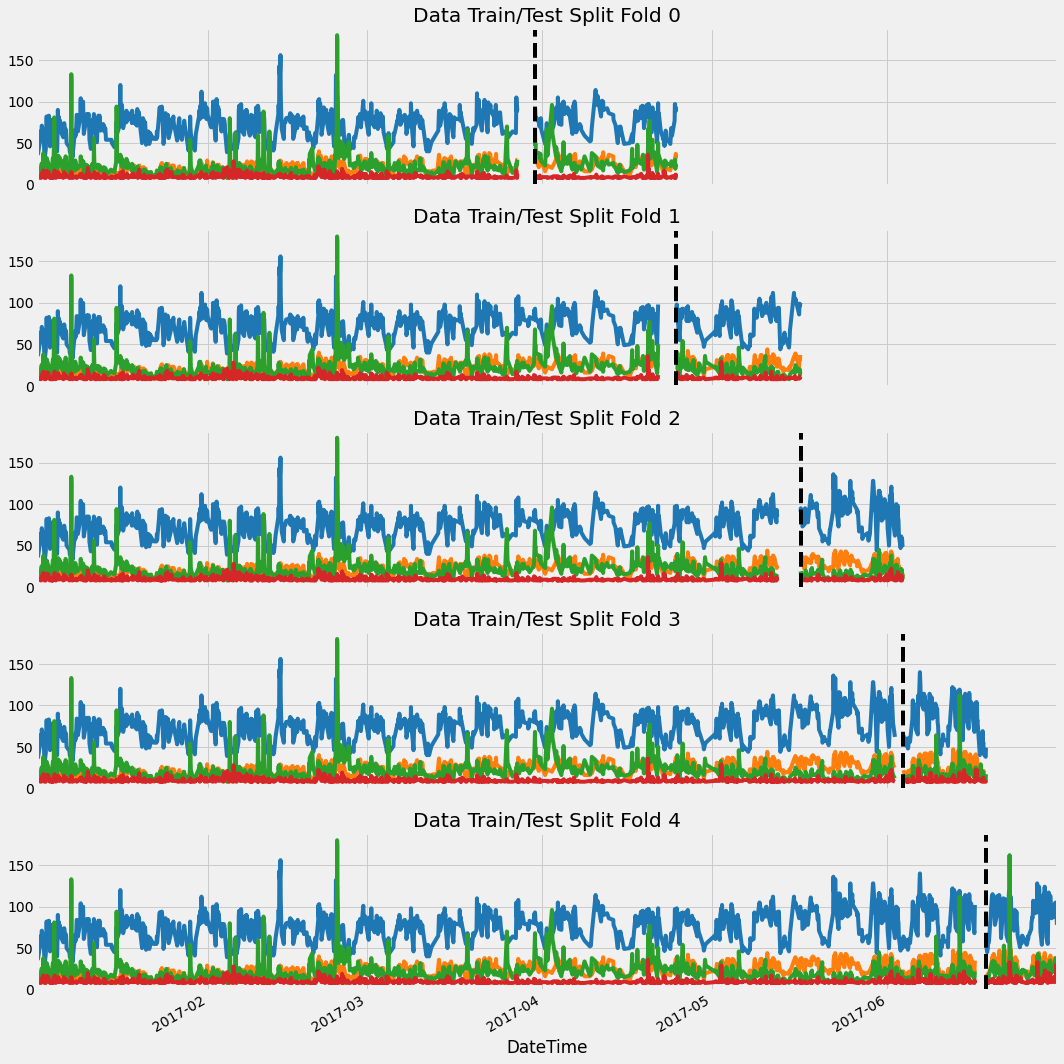

In [27]:
# Time series cross validation
tss = TimeSeriesSplit(n_splits=5, test_size=168, gap=24)
traffic = traffic.sort_index()

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(traffic):
    train = traffic.iloc[train_idx]
    test = traffic.iloc[val_idx]
    
    # Set the x-axis limits to cover the entire time range
    axs[fold].set_xlim(traffic.index.min(), traffic.index.max())
    
    train[['junction 1', 'junction 2', 'junction 3', 'junction 4']].plot(ax=axs[fold], 
                                                                         title=f'Data Train/Test Split Fold {fold}',
                                                                         color=[color_pal[0], color_pal[1], 
                                                                                color_pal[2], color_pal[3]])
    test[['junction 1', 'junction 2', 'junction 3', 'junction 4']].plot(ax=axs[fold], 
                                                                        color=[color_pal[0], color_pal[1], 
                                                                               color_pal[2], color_pal[3]])
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    axs[fold].legend().set_visible(False)  # Hide the legend for the current subplot
    fold += 1

plt.tight_layout()  # Adjust layout spacing
plt.show()

# Notice how it only shows data from 2017--this is because when we executed the > 7 query earlier, we got a 
# dataframe with values from only 2017. This is because prior to 2017, the count of cars in junction 4 was always 0.
# Junction 4 may not have existed before 2017, so it's better to use data from 2017 onwards.

# Lag Features

This is where I told the model to look a target (x) amount of days into the past and use the target value for that many days in the past as a new feature to feed into the model. I added these features into the dataframe.

In [28]:
def add_lags(df):
    target_map_1 = df['junction 1'].to_dict()
    target_map_2 = df['junction 2'].to_dict()
    target_map_3 = df['junction 3'].to_dict()
    target_map_4 = df['junction 4'].to_dict()
    
    df['lag1_j1'] = (df.index - pd.Timedelta(days=105)).map(target_map_1)
    df['lag2_j1'] = (df.index - pd.Timedelta(days=140)).map(target_map_1)
    df['lag3_j1'] = (df.index - pd.Timedelta(days=175)).map(target_map_1)
    
    df['lag1_j2'] = (df.index - pd.Timedelta(days=105)).map(target_map_2)
    df['lag2_j2'] = (df.index - pd.Timedelta(days=140)).map(target_map_2)
    df['lag3_j2'] = (df.index - pd.Timedelta(days=175)).map(target_map_2)
    
    df['lag1_j3'] = (df.index - pd.Timedelta(days=105)).map(target_map_3)
    df['lag2_j3'] = (df.index - pd.Timedelta(days=140)).map(target_map_3)
    df['lag3_j3'] = (df.index - pd.Timedelta(days=175)).map(target_map_3)
    
    df['lag1_j4'] = (df.index - pd.Timedelta(days=105)).map(target_map_4)
    df['lag2_j4'] = (df.index - pd.Timedelta(days=140)).map(target_map_4)
    df['lag3_j4'] = (df.index - pd.Timedelta(days=175)).map(target_map_4)
    
    return df

traffic_with_lags = add_lags(traffic)

# Train with Cross Validation

In [29]:
tss = TimeSeriesSplit(n_splits=5, test_size=168, gap=24)
traffic_with_lags = traffic_with_lags.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(traffic_with_lags):
    train_start_idx = train_idx.min()
    train_end_idx = train_idx.max()
    test_start_idx = val_idx.min()
    test_end_idx = val_idx.max()

    if train_end_idx >= len(traffic_with_lags) or test_end_idx >= len(traffic_with_lags):
        continue  # Skip this fold if the indices are out of bounds

    train = traffic_with_lags.iloc[train_start_idx:train_end_idx + 1]
    test = traffic_with_lags.iloc[test_start_idx:test_end_idx + 1]

    train = time_series_features(train)
    test = time_series_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1_j1','lag2_j1','lag3_j1', 
                'lag1_j2', 'lag2_j2', 'lag3_j2', 
                'lag1_j3', 'lag2_j3', 'lag3_j3', 
                'lag1_j4', 'lag2_j4', 'lag3_j4']
    TARGET = ['junction 1', 'junction 2', 'junction 3', 'junction 4']

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[16:34:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:41.41298	validation_1-rmse:45.47634
[100]	validation_0-rmse:16.91770	validation_1-rmse:20.02247
[200]	validation_0-rmse:9.17157	validation_1-rmse:11.47195
[300]	validation_0-rmse:7.14401	validation_1-rmse:8.99405
[400]	validation_0-rmse:6.57334	validation_1-rmse:8.53172
[500]	validation_0-rmse:6.26013	validation_1-rmse:8.43325
[600]	validation_0-rmse:6.07758	validation_1-rmse:8.39020
[675]	validation_0-rmse:5.94350	validation_1-rmse:8.39471
[16:34:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:42.22366	validation_1-rmse:45.61511
[100]	validation_0-rmse:17.13973	validation_1

In [30]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 8.3041
Fold scores:[8.369097050358356, 9.467456935218625, 7.079675654184288, 7.269891866368163, 9.334404450979138]


# Predicting the Future

In order to predict the future, there must be retraining on all data, an emtpy dataframe for future date ranges, and those dates must be ran through our feature creation code + lag creation.

In [31]:
# Retrain on all data
traffic_with_lags = time_series_features(traffic_with_lags)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1_j1','lag2_j1','lag3_j1', 
                'lag1_j2', 'lag2_j2', 'lag3_j2', 
                'lag1_j3', 'lag2_j3', 'lag3_j3', 
                'lag1_j4', 'lag2_j4', 'lag3_j4']
TARGET = ['junction 1', 'junction 2', 'junction 3', 'junction 4']

X_all = traffic_with_lags[FEATURES]
y_all = traffic_with_lags[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[16:35:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:44.96915
[100]	validation_0-rmse:18.11539
[200]	validation_0-rmse:9.56420
[300]	validation_0-rmse:7.30836
[400]	validation_0-rmse:6.63816
[499]	validation_0-rmse:6.37833


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [32]:
traffic_with_lags.index.max()

Timestamp('2017-06-30 23:00:00')

In [33]:
# Create future dataframe
future = pd.date_range('2017-06-30','2018-07-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
traffic_with_lags['isFuture'] = False
df_and_future = pd.concat([traffic_with_lags, future_df])
df_and_future = time_series_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [34]:
future_w_features = df_and_future.query('isFuture').copy()

In [35]:
future_w_features[['junction 1', 'junction 2', 'junction 3', 'junction 4']] = reg.predict(future_w_features[FEATURES])

Now that there is some predicted data for a future year, I plotted the future predictions so we can visualize it.

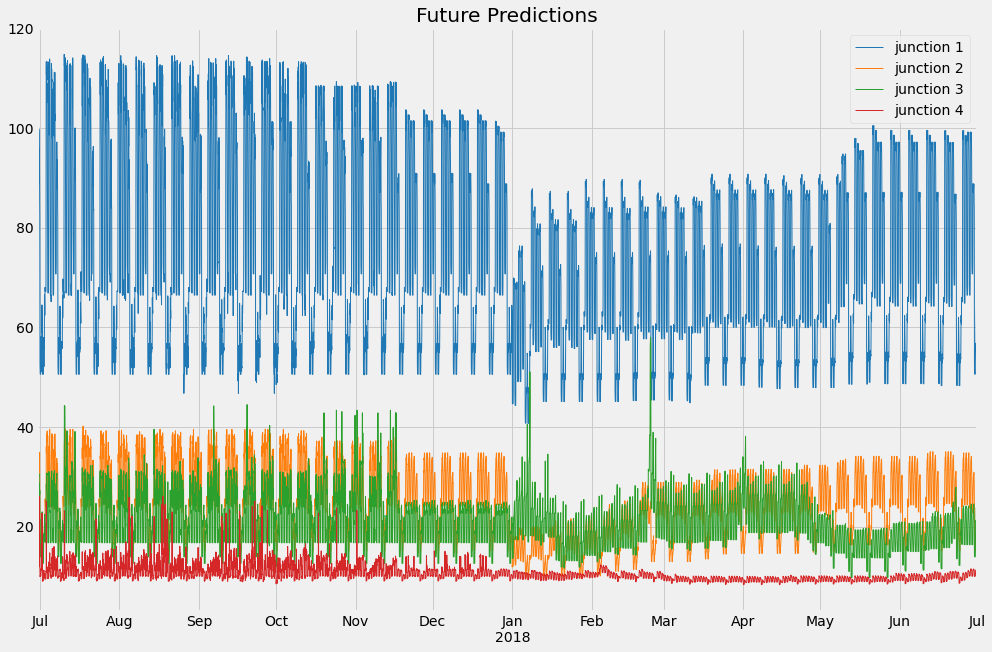

In [36]:
future_w_features[['junction 1', 'junction 2', 'junction 3', 'junction 4']].plot(figsize=(15, 10),
                               ms=1,
                               lw=1,
                               title='Future Predictions', color=[color_pal[0], color_pal[1], 
                                                                                color_pal[2], color_pal[3]])
plt.show()

We can also see the dataframe for future dates.

In [37]:
future_w_features[['junction 1', 'junction 2', 'junction 3', 'junction 4']]

,junction 1,junction 2,junction 3,junction 4
2017-06-30 00:00:00,78.565201,29.537367,17.117342,10.032949
2017-06-30 01:00:00,73.430954,28.575098,16.752060,10.217673
2017-06-30 02:00:00,70.713722,26.421238,16.752060,10.025871
2017-06-30 03:00:00,70.713722,25.037493,16.752060,10.025871
2017-06-30 04:00:00,70.713722,23.898430,16.752060,10.025871
...,...,...,...,...
2018-06-30 20:00:00,64.010162,19.433294,24.310989,11.178433
2018-06-30 21:00:00,62.698204,18.810472,24.310989,11.149452
2018-06-30 22:00:00,62.405617,18.537491,21.407421,11.149452
2018-06-30 23:00:00,60.936161,18.525917,22.255938,11.149452
